In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.use_jedi = False


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from functions.plotting import *
from functions.utils import *
from functions.basicqc import *

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'png'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import annotation and expressions (downloaded previously)

insert here some info about the dataset (links, etc)

In [8]:
#read data
dataset_name = 'PUB_SKCM_HugoMAPK_GSE65185/raw/'
platform_name = 'RNAseq'
path_name = f'datasets/{dataset_name}/'
exp = read_dataset(f"{path_name}/expressions.tsv.gz")
print(exp.shape)

(18, 20062)


In [9]:
exp = exp.T
exp.head()

,GSM1588852,GSM1588854,GSM1588857,GSM1588861,GSM1588863,GSM1588867,GSM1588870,GSM1588874,GSM1588877,GSM1588887,GSM1588890,GSM1588892,GSM1588895,GSM1588897,GSM1588900,GSM1588906,GSM1588910,GSM1588912
A1BG,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.075359,0.139602,0.066858,0.000000,0.000000,0.000000,0.000000,0.000000,0.203685,0.000000,0.000000,0.000000
A1CF,0.116761,0.034991,0.116395,0.025433,0.00000,0.061755,0.075791,0.124787,0.000000,0.075832,0.000000,0.013094,0.015151,0.023811,0.016625,0.019021,0.008579,0.019346
A2M,7.024942,7.469397,8.186774,9.888107,8.35538,7.661804,6.981536,7.792906,7.222781,6.255509,8.511822,8.336725,8.710391,9.849181,9.849889,8.439629,10.414993,6.806859
A2ML1,1.132943,0.120547,4.536428,2.343781,1.98615,0.042919,5.761732,0.527372,5.047149,0.888615,0.044425,0.181231,0.902600,0.260017,0.122215,0.216732,0.294238,0.000000
A3GALT2,0.000000,0.091319,0.197482,0.706437,0.00000,0.000000,0.131010,0.760824,0.000000,0.481818,0.161851,0.000000,0.394407,0.124618,0.798178,0.101585,0.000000,0.198137


# Basic expression QC

## log-scaling check

In [10]:
check_log_scaling(exp.T)

Maximum of average gene values is below 20.
Probably Log-scaled


## detect outliers 

In [11]:
#Median deviation of PCA components>6
e = exp.T.dropna()
out_index = iterative_pca_outliers(e)
out_index

There are no outliers


[]

## detect low-correlated samples

In [12]:
low_index = detect_low_correlation(exp,corr_threshold=0.6)
low_index

All samples are well-correlated


Index([], dtype='object')

## check how many genes are intersecting with TCGA data

In [13]:
intersect_genes_with_pipeline(exp)

20062 out of 20062 genes are intersected with the pipeline (20062 genes).


## check how many of intersected genes have all zero values

In [14]:
percent_zero_columns_for_intersected_genes(exp)

2.34%(469) of intersected genes are all equal to 0, if all values are non-negative.


## check negative values

In [15]:
# there shoud be no negative values. it's a sign of some norm technique we don't use
check_negative_values(exp)

The dataset has no negative values.


# check distribution

## distplot by samples

In [16]:
exp = exp.T

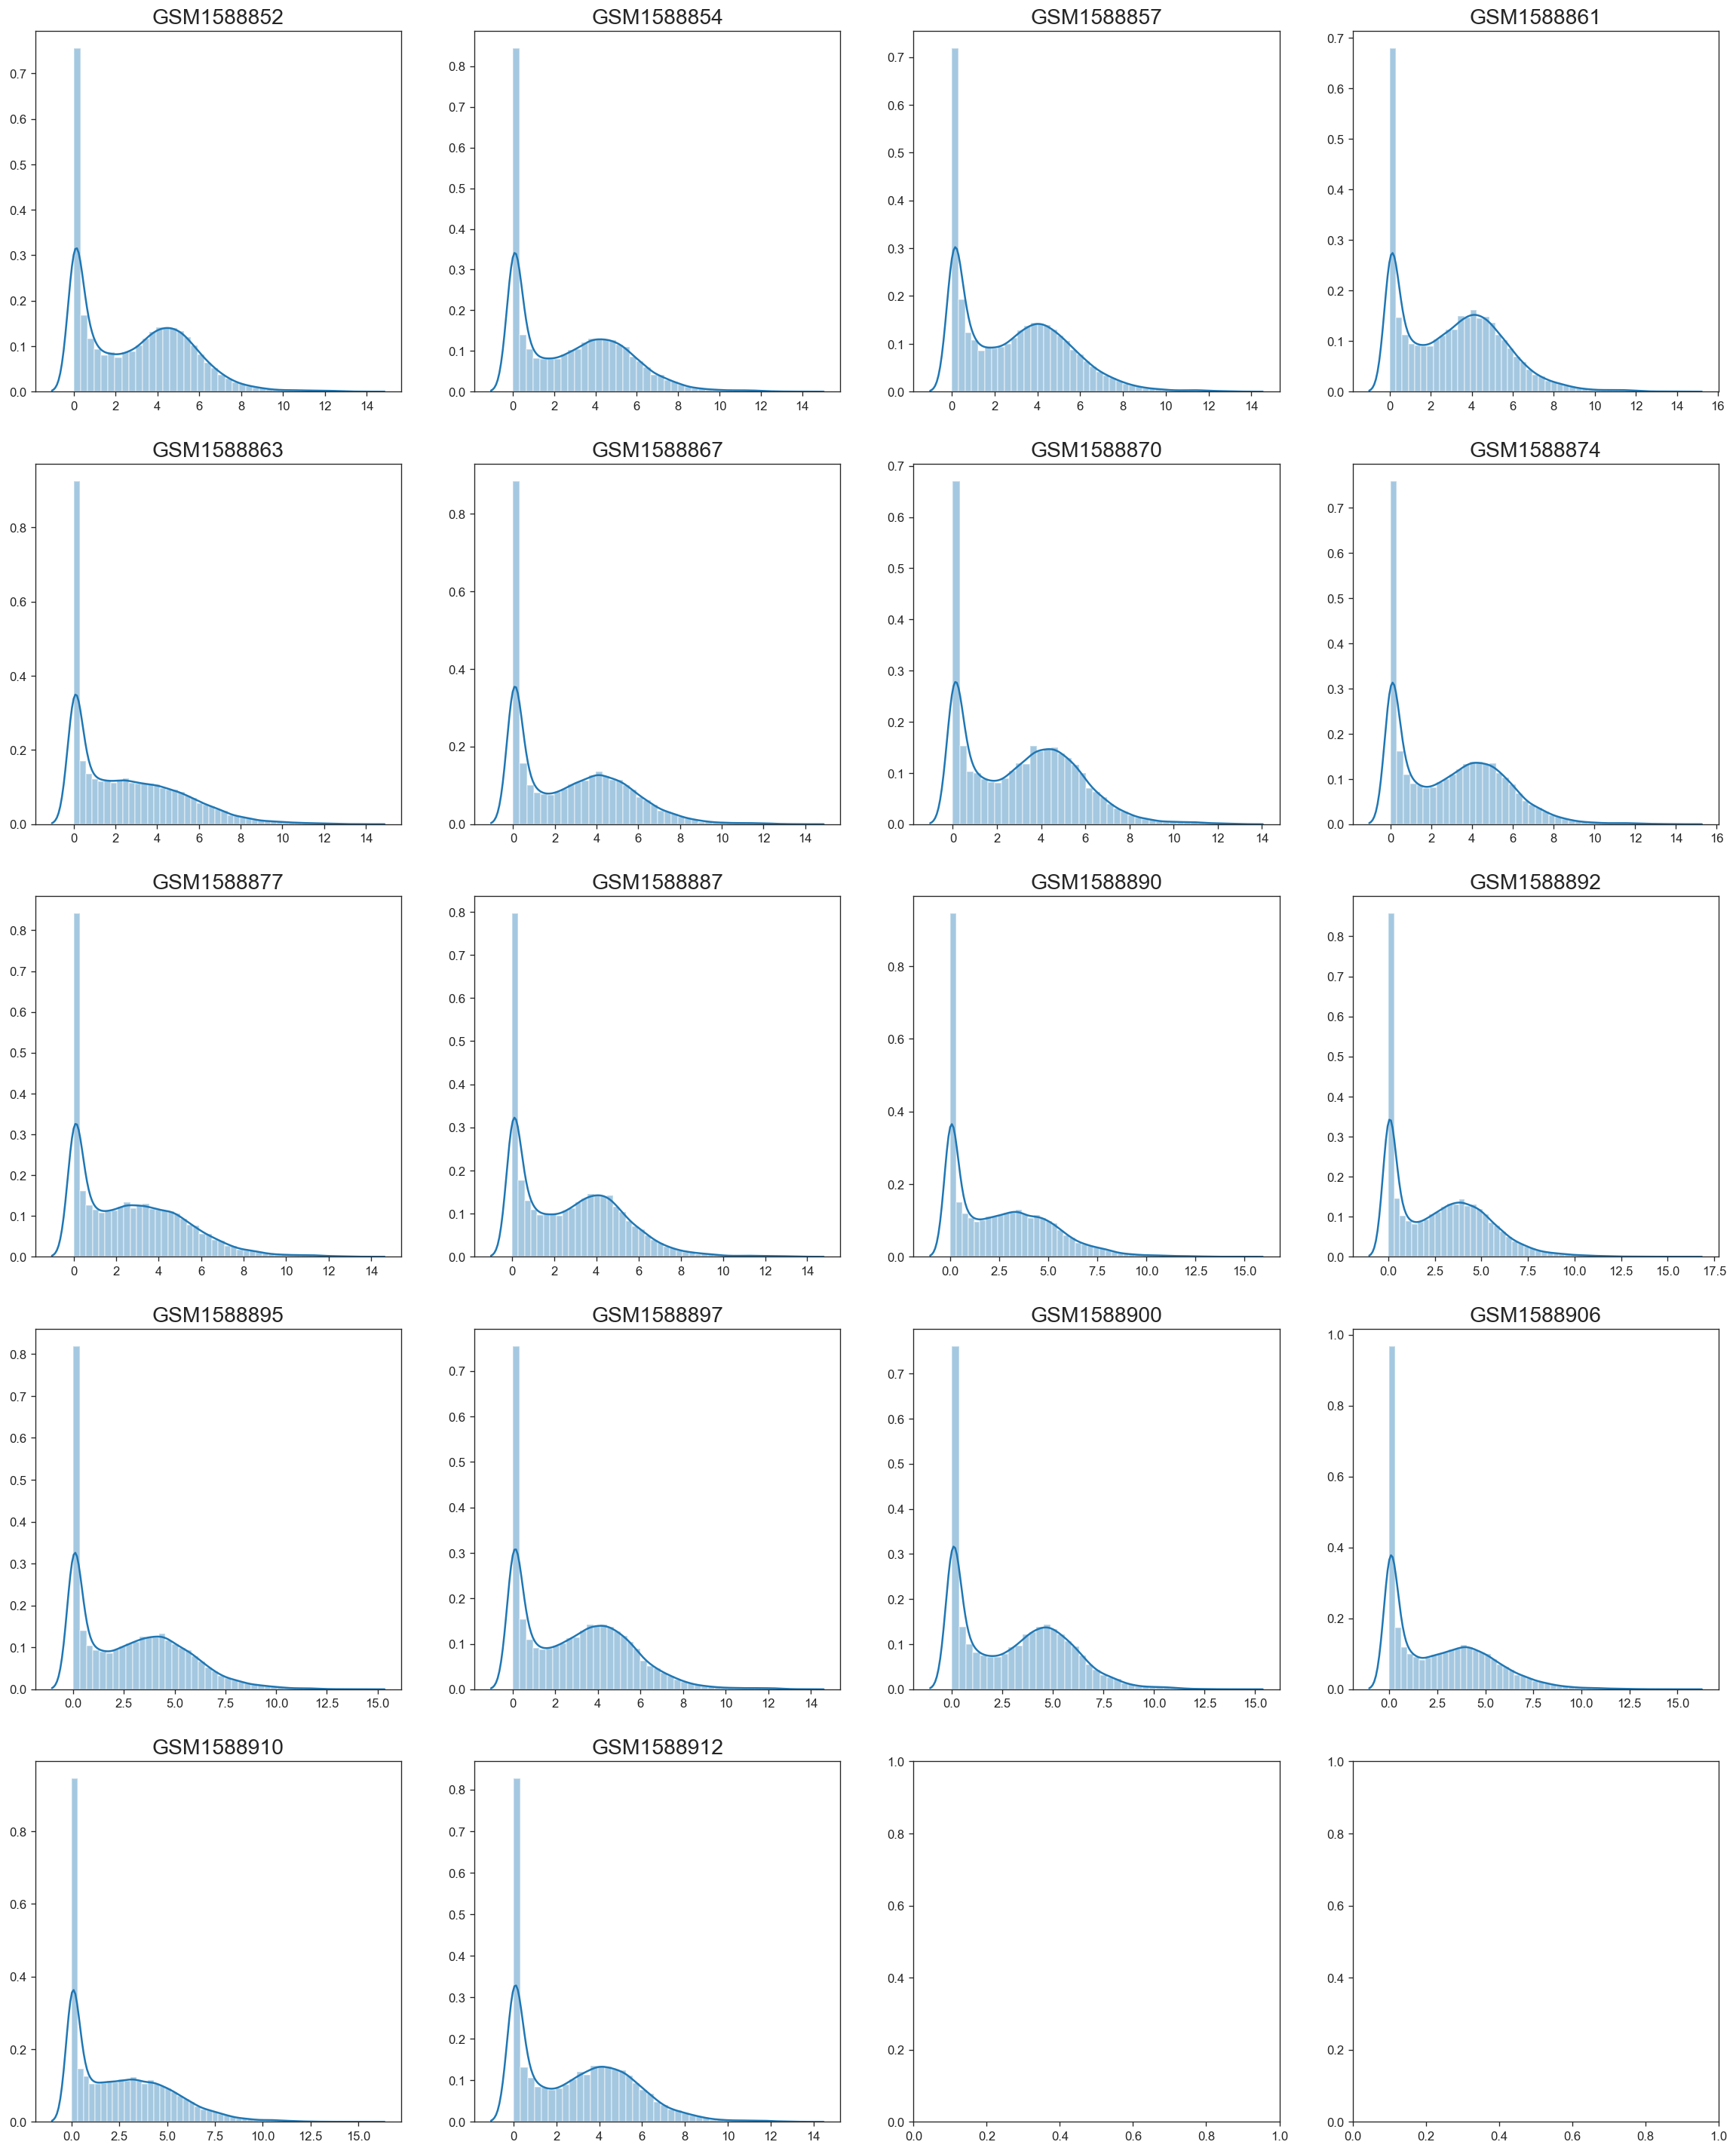

In [17]:
panels_by_horizontal = 4
panels_by_vertical = 5
n_panels_per_plot = panels_by_horizontal * panels_by_vertical

counter = 0
for i in exp.index: #Пациенты в индексах
    if counter == n_panels_per_plot:
        counter = 0
        plt.show()
    if counter == 0:
        af = axis_net(panels_by_horizontal, panels_by_vertical,
                      y_len = 6, x_len = 6)

    ax = next(af)
    if not check_log_scaling(exp,return_scaling=True,verbose=False):
        sns.distplot(exp.loc[i],ax=ax)
    else:
        sns.distplot(np.log2(exp.loc[i]+1),ax=ax) #Если лог-шкалированы
    ax.set_title(i, size = 17)
    ax.set(xlabel=None)
    ax.set(ylabel=None)

    counter += 1

## mean distplot

Text(0.5, 1.0, 'Log2-scaled+1 mean intensity of PUB_SKCM_HugoMAPK_GSE65185/raw/, RNAseq')

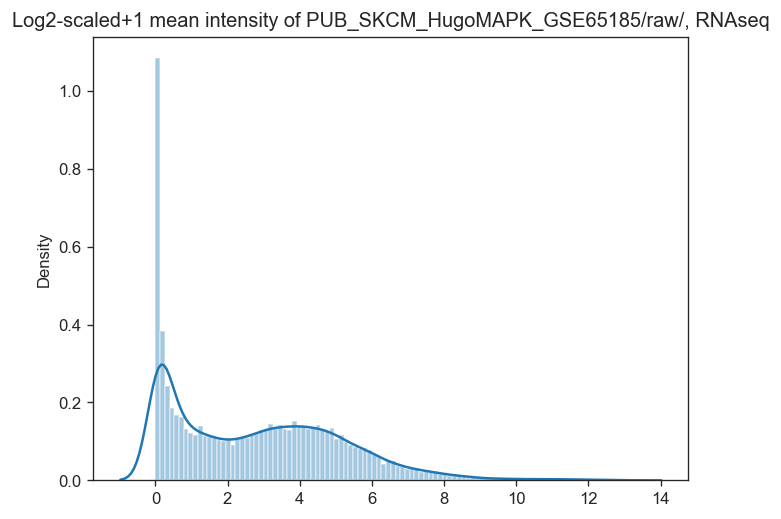

In [18]:
sns.distplot(exp.mean(), bins=100)
plt.title(f'Log2-scaled+1 mean intensity of {dataset_name}, {platform_name}')

## distplot for only intersected genes

Text(0.5, 1.0, 'Log2-scaled+1 mean intensity of PUB_SKCM_HugoMAPK_GSE65185/raw/, RNAseq, only pipeline genes')

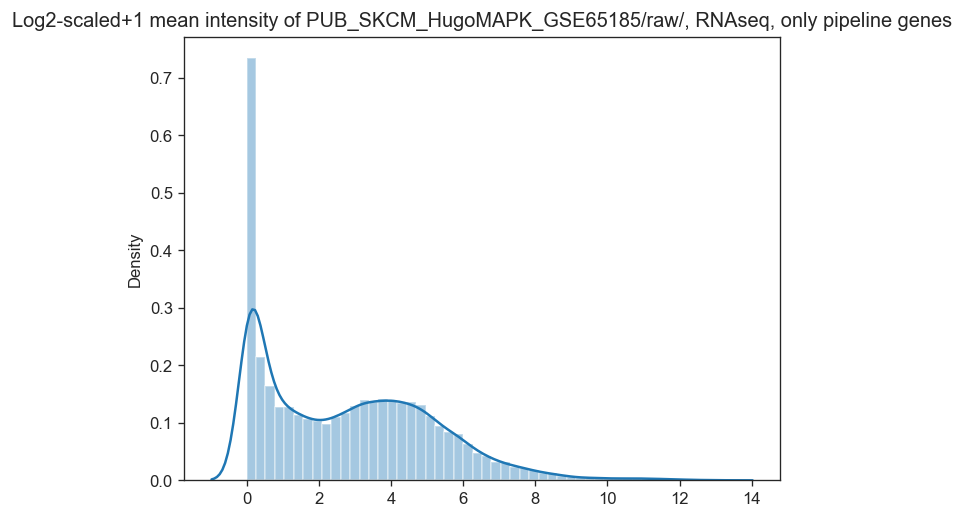

In [19]:
intersection = intersect_genes_with_pipeline(exp.T, return_genes=True, verbose=False)
sns.distplot(exp.mean().loc[intersection], bins=50)
plt.title(f'Log2-scaled+1 mean intensity of {dataset_name}, {platform_name}, only pipeline genes')

# PCA

## with reference TCGA cohort

In [20]:
ann = pd.DataFrame(index=exp.index, columns=['series_id'])
ann['series_id'] = 'RNAseq'


In [21]:
tcga_anno = read_dataset('datasets/TCGA-SKCM/refined_annotation.tsv')
tcga_exp = read_dataset('datasets/TCGA-SKCM/expressions.tsv.gz')

In [22]:
a = pd.concat([tcga_anno['Diagnosis.TCGA_recombined_cohort'], ann['series_id']])
e = pd.concat([np.log2(tcga_exp+1), exp.T], axis=1).dropna()
e,a = to_common_samples((e.T,a.dropna()))

Text(0.5, 1.0, 'PCA plot for PUB_SKCM_HugoMAPK_GSE65185/raw/ vs TCGA, log2-scaled+1 genes')

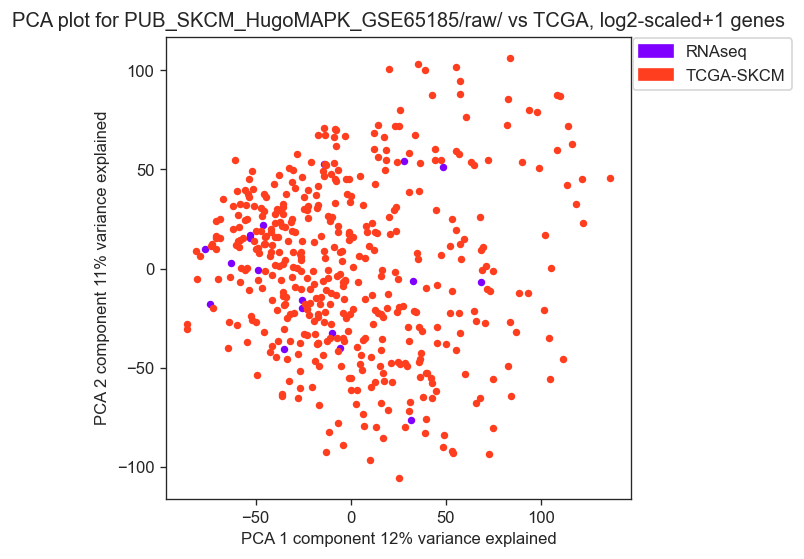

In [23]:
# let's see how it looks with a very different method of the same diagnosis
pca_plot(e,a)
plt.title(f'PCA plot for {dataset_name} vs TCGA, log2-scaled+1 genes')

## within a cohort

Text(0.5, 1.0, 'PCA plot for PUB_SKCM_HugoMAPK_GSE65185/raw/, log2-scaled+1 genes')

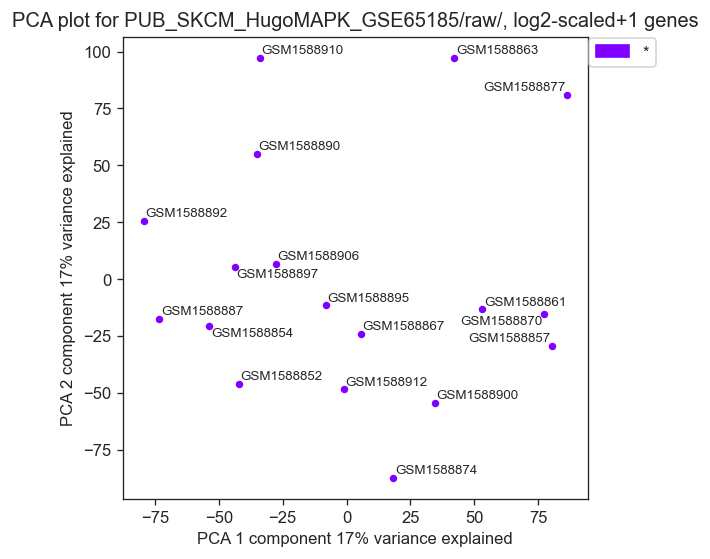

In [24]:
# check if there is any inner batch
pca_plot(exp,label_samples=True)
plt.title(f'PCA plot for {dataset_name}, log2-scaled+1 genes')

# Check if there are any low-correlated samples

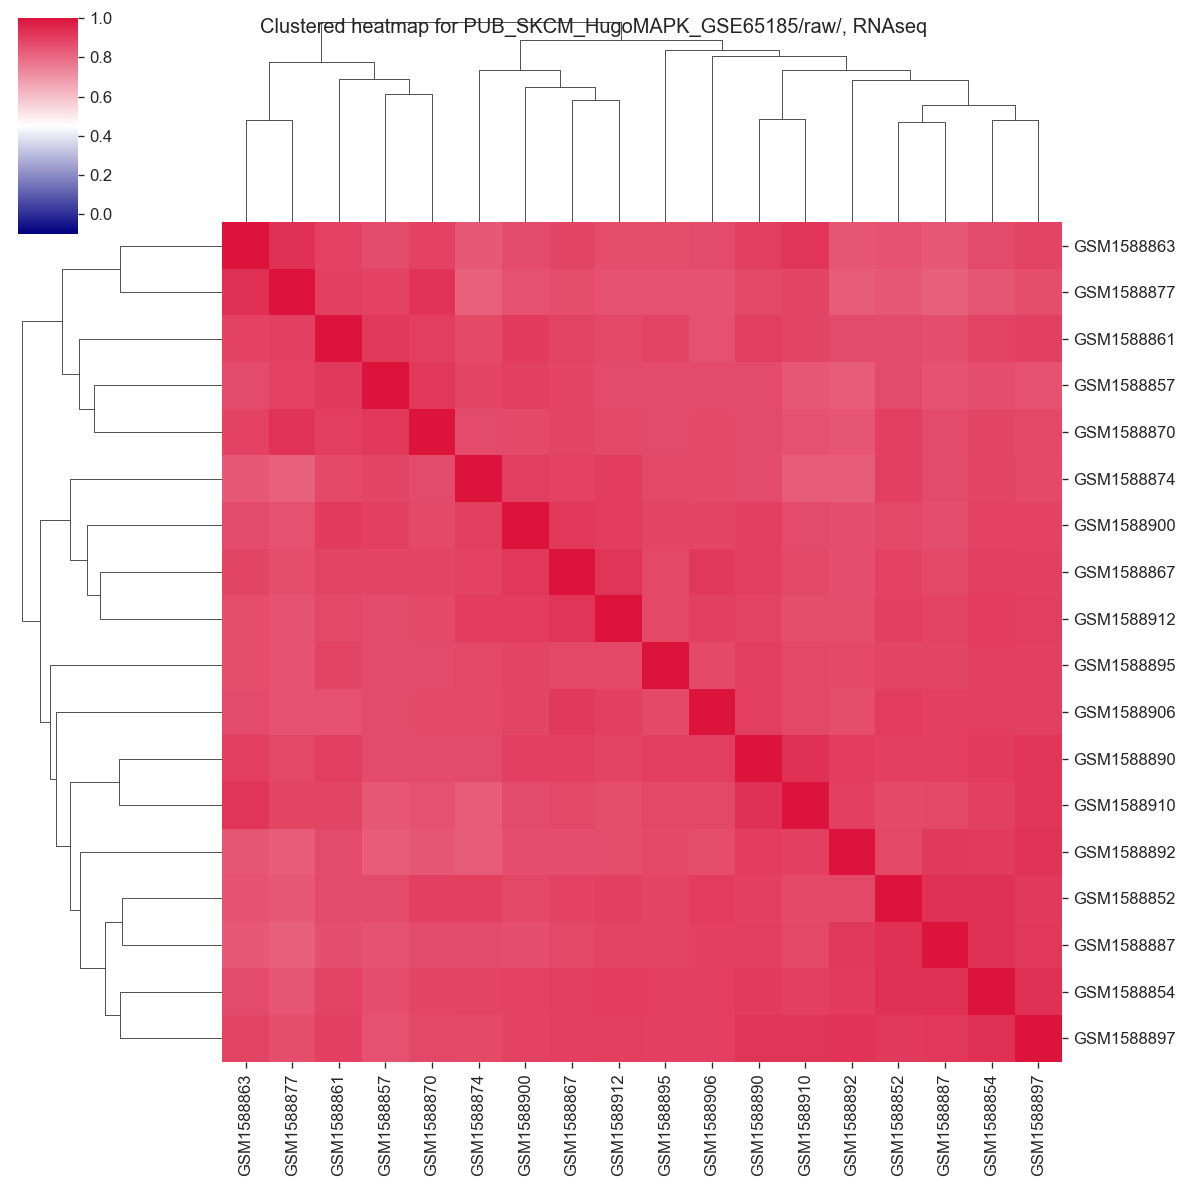

In [25]:
# all samples should be well correlated (correlation>0.6)
a = clustering_heatmap(exp, corr='spearman',title=f'Clustered heatmap for {dataset_name}, {platform_name}',
    method='average',figsize=(10,10),vmin=-0.1, cmap=default_cmap)
xticklabels = [label.get_text() for label in a.ax_heatmap.xaxis.get_ticklabels()]

# Cumulative sum plot

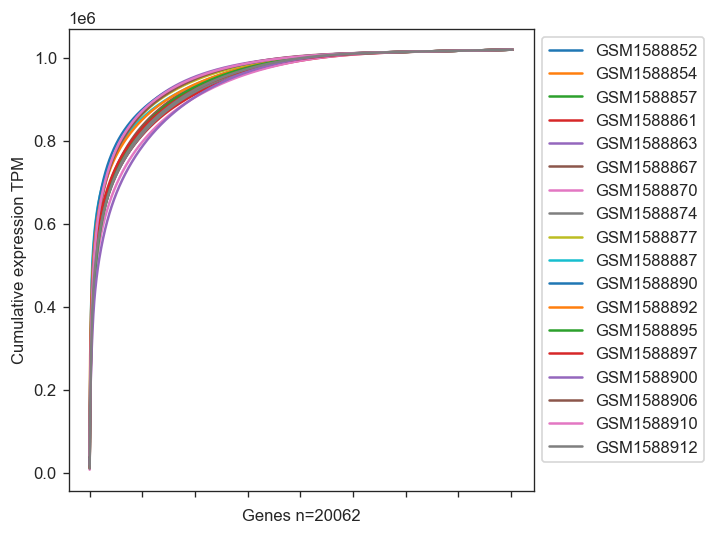

In [26]:
fig,ax=plt.subplots(figsize=(5,5))
for sample in exp.index:
    np.exp2(exp).loc[sample].sort_values(ascending=False).dropna().cumsum().reset_index(drop=True).plot(kind='line',ax=ax)
    ax.set_xticklabels([])

plt.xlabel(f'Genes n={len(exp.columns)}')
plt.ylabel('Cumulative expression TPM')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# Create 'refined' annotation

In [27]:
wtf = ['SRX849782','SRX849784','SRX849787','SRX849791','SRX849793','SRX849797','SRX849800','SRX849804','SRX849807','SRX849781','SRX849816','SRX849818','SRX849821','SRX849823','SRX849826','SRX849832','SRX849836','SRX849838']
exp['SRX'] = wtf
exp['GSM'] = exp.index
exp.set_index('SRX', inplace=True)

In [36]:
exp = exp.set_index(ann.index)

In [37]:
exp

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk,GSM
GSM1588852,0.000000,0.116761,7.024942,1.132943,0.000000,1.164737,0.118467,4.756719,2.560478,0.246325,...,2.422804,3.414035,3.481300,0.265115,3.455766,5.952471,4.226331,5.098261,2.355938,GSM1588852
GSM1588854,0.000000,0.034991,7.469397,0.120547,0.091319,1.981783,0.096946,5.229934,1.872699,0.154994,...,1.815035,2.708326,3.346815,0.111464,3.506377,6.411307,3.579627,4.607768,1.712884,GSM1588854
GSM1588857,0.000000,0.116395,8.186774,4.536428,0.197482,1.533030,0.105466,4.804193,4.412055,1.474443,...,0.872598,2.405044,3.571256,0.367805,3.020086,7.705630,3.162089,3.746261,3.407781,GSM1588857
GSM1588861,0.000000,0.025433,9.888107,2.343781,0.706437,3.787385,0.000000,5.097530,3.930623,0.524496,...,1.296190,2.076149,3.632867,0.210068,2.777934,8.494621,3.480334,3.826706,4.239071,GSM1588861
GSM1588863,0.000000,0.000000,8.355380,1.986150,0.000000,4.314246,0.000000,5.882470,3.811683,0.630001,...,0.558399,1.438082,1.977904,0.068820,1.404986,8.221095,3.279986,1.703291,1.979993,GSM1588863
GSM1588867,0.000000,0.061755,7.661804,0.042919,0.000000,4.235499,0.000000,4.911482,3.193384,0.094927,...,1.337059,2.287984,2.315980,0.100476,2.898433,8.415710,2.986646,4.332365,3.602762,GSM1588867
GSM1588870,0.075359,0.075791,6.981536,5.761732,0.131010,2.021130,0.071262,5.390891,4.522808,1.508421,...,1.105934,2.365993,3.696838,0.254735,3.485754,6.531298,3.952975,4.289999,3.377397,GSM1588870
GSM1588874,0.139602,0.124787,7.792906,0.527372,0.760824,2.160864,0.000000,5.117079,3.500541,0.202440,...,1.417023,2.323565,3.326624,0.169997,2.949856,6.804268,3.025592,4.127213,3.251421,GSM1588874
GSM1588877,0.066858,0.000000,7.222781,5.047149,0.000000,3.394338,0.041524,5.512954,4.853825,1.292191,...,0.912571,1.438795,2.771497,0.093038,2.003402,7.284773,3.220718,1.732534,2.681464,GSM1588877
GSM1588887,0.000000,0.075832,6.255509,0.888615,0.481818,0.870360,0.208326,2.440440,2.051635,0.000000,...,1.267050,2.213512,2.841939,0.337850,3.255524,5.182822,6.043310,4.406657,2.623072,GSM1588887


In [29]:
anno = {}
anno['Cohort'] = pd.Series(index=exp.index,data = 'Hugo_MAPK')
anno['GSM'] = pd.Series(index=exp.index, data = exp['GSM'])
anno['SRX'] = exp.index
anno['Transcriptomics'] = pd.Series(index=exp.index,data = 'RNAseq')
anno['Accession_number'] = pd.Series(index=exp.index,data = 'GSE65185')
anno['series_id'] = pd.Series(index=exp.index, data = 'GSE65185')
anno['Diagnosis'] = pd.Series(index=exp.index, data = 'Cutaneous_Melanoma')
anno['Therapy'] = pd.Series(index=exp.index, data = 'none')
anno['Biopsy_pre_or_post'] = pd.Series(index=exp.index, data = 'Pre')
anno['Sample_title'] = pd.Series(index=exp.index, data = (f'Pt {i} baseline' for i in [1,2,3,4,6,8,9,10,15,16,17,18,19,20,21,22,23,24]))
anno['Response'] = pd.Series(index=exp.index, data = 'R')
anno['Site'] = pd.Series(index=exp.index, data = 'tumor biopsy')
anno['Male'] = pd.Series(index=exp.index, data = ['F' if i in ['SRX849787', 'SRX849800', 'SRX849804', 'SRX849781', 'SRX849818'] else 'M' for i in exp.index])
anno['Age'] = pd.Series(index=exp.index, data=[51,65,66,61,83,47,47,65,65,51,41,41,58,59,47,37,67,69])


In [38]:
anno_with_outliers = pd.DataFrame(anno)
anno_with_outliers = anno_with_outliers.set_index(ann.index)

In [39]:
anno_with_outliers

,Cohort,GSM,SRX,Transcriptomics,Accession_number,series_id,Diagnosis,Therapy,Biopsy_pre_or_post,Sample_title,Response,Site,Male,Age
GSM1588852,Hugo_MAPK,GSM1588852,SRX849782,RNAseq,GSE65185,GSE65185,Cutaneous_Melanoma,none,Pre,Pt 1 baseline,R,tumor biopsy,M,51
GSM1588854,Hugo_MAPK,GSM1588854,SRX849784,RNAseq,GSE65185,GSE65185,Cutaneous_Melanoma,none,Pre,Pt 2 baseline,R,tumor biopsy,M,65
GSM1588857,Hugo_MAPK,GSM1588857,SRX849787,RNAseq,GSE65185,GSE65185,Cutaneous_Melanoma,none,Pre,Pt 3 baseline,R,tumor biopsy,F,66
GSM1588861,Hugo_MAPK,GSM1588861,SRX849791,RNAseq,GSE65185,GSE65185,Cutaneous_Melanoma,none,Pre,Pt 4 baseline,R,tumor biopsy,M,61
GSM1588863,Hugo_MAPK,GSM1588863,SRX849793,RNAseq,GSE65185,GSE65185,Cutaneous_Melanoma,none,Pre,Pt 6 baseline,R,tumor biopsy,M,83
GSM1588867,Hugo_MAPK,GSM1588867,SRX849797,RNAseq,GSE65185,GSE65185,Cutaneous_Melanoma,none,Pre,Pt 8 baseline,R,tumor biopsy,M,47
GSM1588870,Hugo_MAPK,GSM1588870,SRX849800,RNAseq,GSE65185,GSE65185,Cutaneous_Melanoma,none,Pre,Pt 9 baseline,R,tumor biopsy,F,47
GSM1588874,Hugo_MAPK,GSM1588874,SRX849804,RNAseq,GSE65185,GSE65185,Cutaneous_Melanoma,none,Pre,Pt 10 baseline,R,tumor biopsy,F,65
GSM1588877,Hugo_MAPK,GSM1588877,SRX849807,RNAseq,GSE65185,GSE65185,Cutaneous_Melanoma,none,Pre,Pt 15 baseline,R,tumor biopsy,M,65
GSM1588887,Hugo_MAPK,GSM1588887,SRX849781,RNAseq,GSE65185,GSE65185,Cutaneous_Melanoma,none,Pre,Pt 16 baseline,R,tumor biopsy,F,51


# Save anno and expr

In [40]:
check_log_scaling(exp)

TypeError: Could not convert ['GSM1588852GSM1588854GSM1588857GSM1588861GSM1588863GSM1588867GSM1588870GSM1588874GSM1588877GSM1588887GSM1588890GSM1588892GSM1588895GSM1588897GSM1588900GSM1588906GSM1588910GSM1588912'] to numeric

In [42]:
exp.head()

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk,GSM
GSM1588852,0.0,0.116761,7.024942,1.132943,0.000000,1.164737,0.118467,4.756719,2.560478,0.246325,...,2.422804,3.414035,3.481300,0.265115,3.455766,5.952471,4.226331,5.098261,2.355938,GSM1588852
GSM1588854,0.0,0.034991,7.469397,0.120547,0.091319,1.981783,0.096946,5.229934,1.872699,0.154994,...,1.815035,2.708326,3.346815,0.111464,3.506377,6.411307,3.579627,4.607768,1.712884,GSM1588854
GSM1588857,0.0,0.116395,8.186774,4.536428,0.197482,1.533030,0.105466,4.804193,4.412055,1.474443,...,0.872598,2.405044,3.571256,0.367805,3.020086,7.705630,3.162089,3.746261,3.407781,GSM1588857
GSM1588861,0.0,0.025433,9.888107,2.343781,0.706437,3.787385,0.000000,5.097530,3.930623,0.524496,...,1.296190,2.076149,3.632867,0.210068,2.777934,8.494621,3.480334,3.826706,4.239071,GSM1588861
GSM1588863,0.0,0.000000,8.355380,1.986150,0.000000,4.314246,0.000000,5.882470,3.811683,0.630001,...,0.558399,1.438082,1.977904,0.068820,1.404986,8.221095,3.279986,1.703291,1.979993,GSM1588863


In [43]:
exp.drop('GSM', axis=1, inplace=True)

In [44]:
exp

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
GSM1588852,0.000000,0.116761,7.024942,1.132943,0.000000,1.164737,0.118467,4.756719,2.560478,0.246325,...,4.420918,2.422804,3.414035,3.481300,0.265115,3.455766,5.952471,4.226331,5.098261,2.355938
GSM1588854,0.000000,0.034991,7.469397,0.120547,0.091319,1.981783,0.096946,5.229934,1.872699,0.154994,...,5.212262,1.815035,2.708326,3.346815,0.111464,3.506377,6.411307,3.579627,4.607768,1.712884
GSM1588857,0.000000,0.116395,8.186774,4.536428,0.197482,1.533030,0.105466,4.804193,4.412055,1.474443,...,5.237868,0.872598,2.405044,3.571256,0.367805,3.020086,7.705630,3.162089,3.746261,3.407781
GSM1588861,0.000000,0.025433,9.888107,2.343781,0.706437,3.787385,0.000000,5.097530,3.930623,0.524496,...,5.507029,1.296190,2.076149,3.632867,0.210068,2.777934,8.494621,3.480334,3.826706,4.239071
GSM1588863,0.000000,0.000000,8.355380,1.986150,0.000000,4.314246,0.000000,5.882470,3.811683,0.630001,...,4.840549,0.558399,1.438082,1.977904,0.068820,1.404986,8.221095,3.279986,1.703291,1.979993
GSM1588867,0.000000,0.061755,7.661804,0.042919,0.000000,4.235499,0.000000,4.911482,3.193384,0.094927,...,5.864854,1.337059,2.287984,2.315980,0.100476,2.898433,8.415710,2.986646,4.332365,3.602762
GSM1588870,0.075359,0.075791,6.981536,5.761732,0.131010,2.021130,0.071262,5.390891,4.522808,1.508421,...,4.848542,1.105934,2.365993,3.696838,0.254735,3.485754,6.531298,3.952975,4.289999,3.377397
GSM1588874,0.139602,0.124787,7.792906,0.527372,0.760824,2.160864,0.000000,5.117079,3.500541,0.202440,...,5.332695,1.417023,2.323565,3.326624,0.169997,2.949856,6.804268,3.025592,4.127213,3.251421
GSM1588877,0.066858,0.000000,7.222781,5.047149,0.000000,3.394338,0.041524,5.512954,4.853825,1.292191,...,4.585452,0.912571,1.438795,2.771497,0.093038,2.003402,7.284773,3.220718,1.732534,2.681464
GSM1588887,0.000000,0.075832,6.255509,0.888615,0.481818,0.870360,0.208326,2.440440,2.051635,0.000000,...,4.247389,1.267050,2.213512,2.841939,0.337850,3.255524,5.182822,6.043310,4.406657,2.623072


In [45]:
#make folder for the dataset if it doesn't exist
path = 'datasets/PUB_SKCM_HugoMAPK_GSE65185/'
#save anno
anno_with_outliers.to_csv(path+'refined_annotation.tsv', sep='\t')
exp.T.to_csv(path+'expressions.tsv', sep='\t')